# Section 1: Time Series Decomposition via Codifferencing

In this section, we decompose the daily new COVID-19 cases in India into its structural components: trend, seasonality, and residuals.

Instead of classical methods (like STL or additive decomposition), we use **codifferencing**—a technique well-suited for heavy-tailed or infinite variance data.

Steps:
- Apply codifference with a lag of 14 to remove long-term trend.
- Apply codifference again with a lag of 7 to eliminate weekly seasonality.
- Visualize each stage: original, detrended, and deseasonalized residuals.


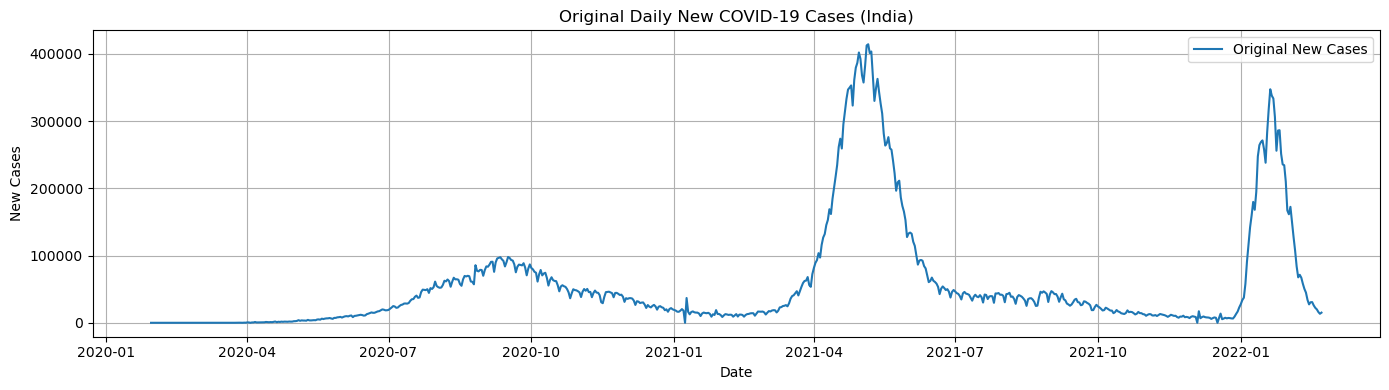

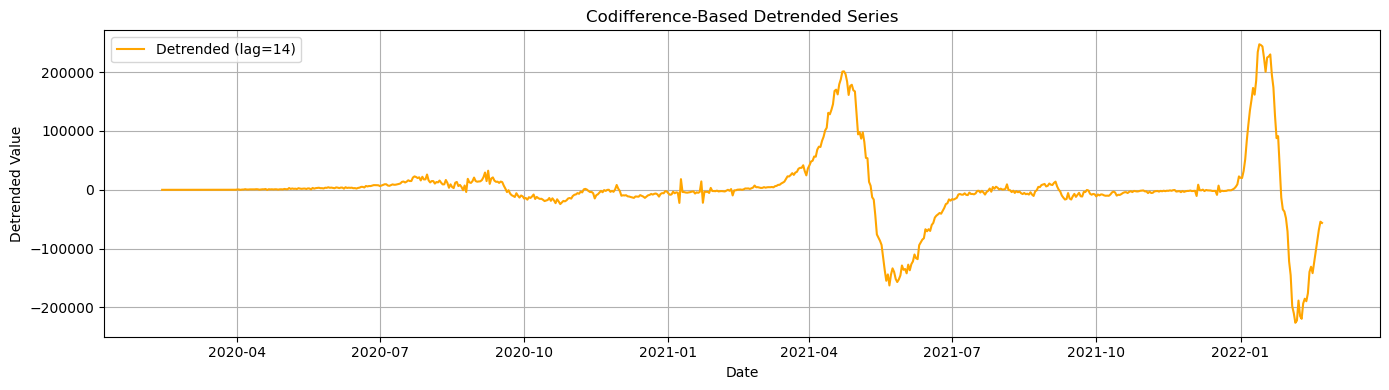

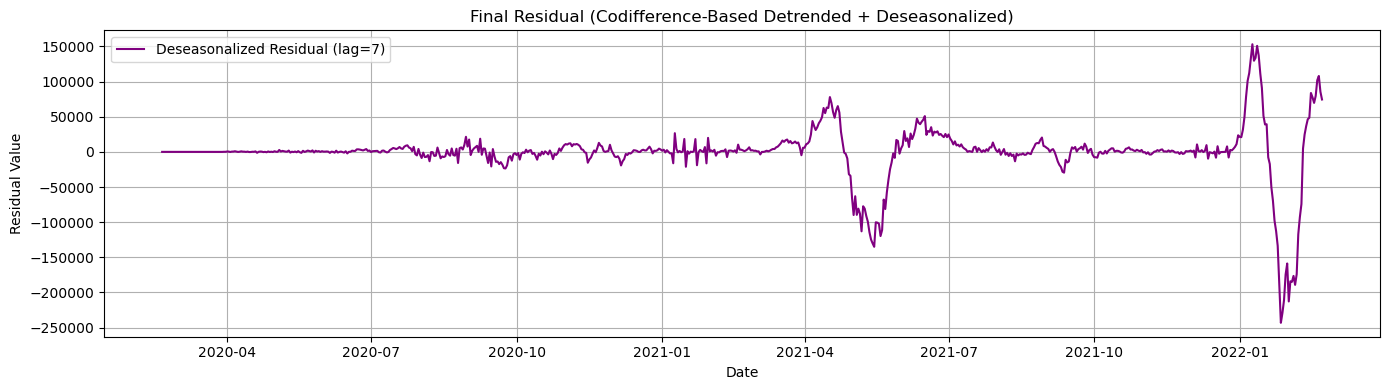

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the dataset
df = pd.read_csv("owid-covid-data.csv")
df_india = df[df['location'] == 'India'][['date', 'new_cases']].copy()

# 2. Preprocess the data
df_india['date'] = pd.to_datetime(df_india['date'])
df_india.set_index('date', inplace=True)
df_india = df_india.asfreq('D')  # Ensure daily frequency
df_india['new_cases'] = df_india['new_cases'].fillna(0)  # Avoid chained assignment
series = df_india['new_cases']

# 3. Codifference function (robust for both Series and NumPy array input)
def codifference(x, lag=1):
    x = np.asarray(x)
    return x[lag:] - x[:-lag]

# 4. Apply codifference-based detrending
trend_lag = 14  # Lag for local trend removal
detrended = codifference(series, lag=trend_lag)
detrended_index = series.index[trend_lag:]

# 5. Apply codifference-based deseasonalizing
seasonal_lag = 7  # Lag for weekly seasonality
deseasonalized = codifference(detrended, lag=seasonal_lag)
final_index = detrended_index[seasonal_lag:]

# ======================
# 6. PLOTS
# ======================

# Plot original series
plt.figure(figsize=(14, 4))
plt.plot(series, label='Original New Cases')
plt.title('Original Daily New COVID-19 Cases (India)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot codifference-based detrended series
plt.figure(figsize=(14, 4))
plt.plot(detrended_index, detrended, label=f'Detrended (lag={trend_lag})', color='orange')
plt.title('Codifference-Based Detrended Series')
plt.xlabel('Date')
plt.ylabel('Detrended Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot final residual after deseasonalization
plt.figure(figsize=(14, 4))
plt.plot(final_index, deseasonalized, label=f'Deseasonalized Residual (lag={seasonal_lag})', color='purple')
plt.title('Final Residual (Codifference-Based Detrended + Deseasonalized)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Section 2: Stationarity and Cyclostationarity Assessment

This section evaluates the statistical properties of the residual series to ensure it is suitable for modeling.

We apply:
- **ADF Test (Augmented Dickey-Fuller):** To test weak stationarity.
- **Rolling MAD of Codifferenced Values:** A robust, variance-independent stationarity check.
- **ADoF (Approximate Degree of Freedom) Test:** Detects periodic (e.g., weekly) structure in the residuals, a hallmark of cyclostationarity.

Interpretations:
- Stationarity suggests stability across time, essential for reliable modeling.
- Cyclostationarity indicates periodic statistical behavior, justifying the use of periodic AR (PAR) models.



--- Stationarity Check ---
ADF Statistic: -8.7561
p-value: 0.0000
Result: Stationary


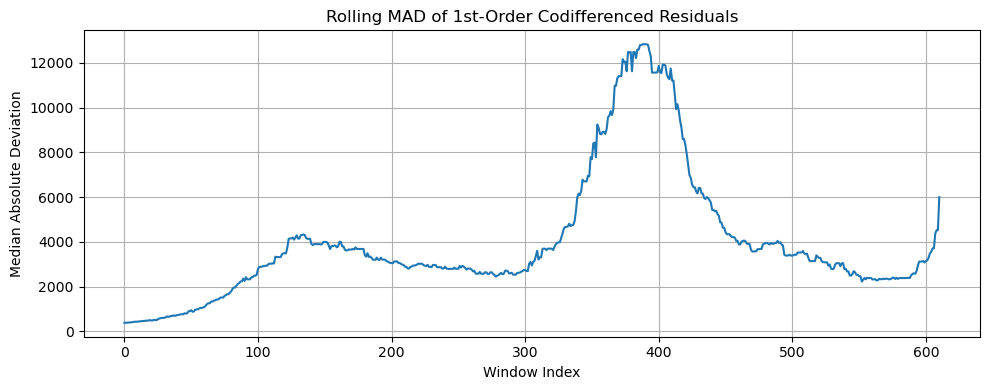


--- Cyclostationarity Check ---
Variance of Phase Medians (ADoF): 47885.989796
Phase Medians: [ -23.  -292.5 -121.5  -11.   378.   315.    -9. ]


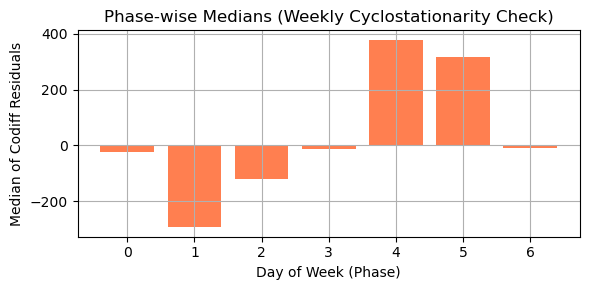


=== Final Summary ===
Stationary (ADF): Yes
Cyclostationary (ADoF Test): Yes


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# === 1. Codifference Function ===
def codifference(x, lag=1):
    return x[lag:] - x[:-lag]

# === 2. Rolling MAD for Codiff Stability ===
def rolling_codiff_mad(series, window=100, lag=1):
    mad_vals = []
    for i in range(len(series) - window):
        chunk = series[i:i+window]
        diff = codifference(chunk, lag)
        mad_vals.append(np.median(np.abs(diff - np.median(diff))))
    return mad_vals

# === 3. ADoF Test for Cyclostationarity ===
def adof_test(series, period):
    phases = [[] for _ in range(period)]
    for t in range(len(series)):
        phases[t % period].append(series[t])
    medians = [np.median(phase) for phase in phases]
    variance = np.var(medians)
    return variance, medians

# === 4. Apply to Residual Series ===
y = residual_series.values
index = residual_series.index
y_diff = codifference(y, lag=1)

# === 5. ADF Test ===
print("\n--- Stationarity Check ---")
try:
    adf_stat, p_val, *_ = adfuller(y_diff)
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
    adf_result = p_val < 0.05
    print("Result: Stationary" if adf_result else "Result: Not Stationary")
except Exception as e:
    print("ADF Test failed (likely infinite variance):", e)
    adf_result = None

# === 6. Rolling MAD Plot ===
mad_vals = rolling_codiff_mad(y, window=100, lag=1)

plt.figure(figsize=(10, 4))
plt.plot(mad_vals, label="Rolling MAD")
plt.title("Rolling MAD of 1st-Order Codifferenced Residuals")
plt.xlabel("Window Index")
plt.ylabel("Median Absolute Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Infer from MAD plot: if mostly flat → stationary
mad_std = np.std(mad_vals)
mad_mean = np.mean(mad_vals)
stationary_from_mad = mad_std / mad_mean < 0.3  # empirical threshold

# === 7. ADoF Test for Daily Periodicity ===
print("\n--- Cyclostationarity Check ---")
period = 7
adof_var, phase_medians = adof_test(y_diff, period)

print(f"Variance of Phase Medians (ADoF): {adof_var:.6f}")
print(f"Phase Medians: {np.round(phase_medians, 3)}")

plt.figure(figsize=(6, 3))
plt.bar(range(period), phase_medians, color='coral')
plt.title("Phase-wise Medians (Weekly Cyclostationarity Check)")
plt.xlabel("Day of Week (Phase)")
plt.ylabel("Median of Codiff Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

cyclostationary = adof_var > 1e-3  # empirical threshold

# === 8. Final Summary ===
print("\n=== Final Summary ===")
if adf_result is not None:
    print(f"Stationary (ADF): {'Yes' if adf_result else 'No'}")
else:
    print(f"Stationary (MAD-based): {'Yes' if stationary_from_mad else 'No'}")
print(f"Cyclostationary (ADoF Test): {'Yes' if cyclostationary else 'No'}")





# Section 3: Infinite Variance Check via Hill Estimator

Heavy-tailed time series often violate finite variance assumptions of classical time series models.

In this section:
- A **boxplot** visualizes the spread and extremity of residuals.
- The **Hill Estimator** is used to estimate the tail index (α).  
  A value of α < 2 indicates infinite variance.

If α < 2:
- Use of traditional AR models becomes questionable.
- Alternative models (like α-stable AR or codifference-based estimation) are more appropriate.


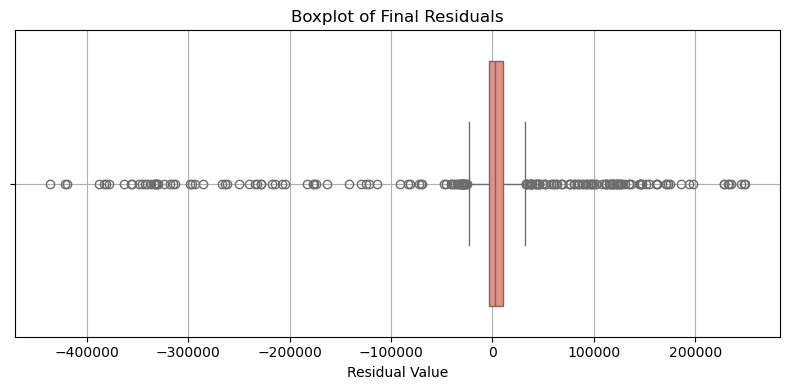

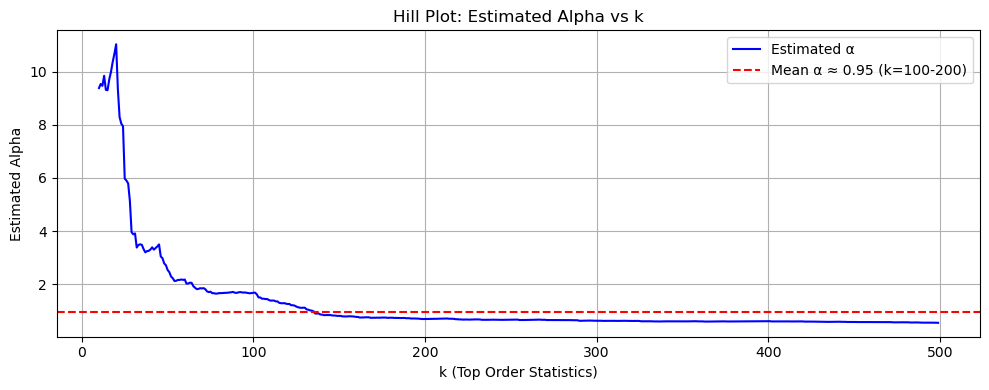

In [31]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

# 1. Boxplot to check for heavy tails
plt.figure(figsize=(8, 4))
sns.boxplot(x=residual_series, color='salmon')
plt.title('Boxplot of Final Residuals')
plt.xlabel('Residual Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Hill estimator function
def hill_estimator(data, k_values):
    data = np.sort(np.abs(data))[::-1]
    hill_estimates = []
    for k in k_values:
        if k < len(data):
            top_k = data[:k]
            hill = (1 / k) * np.sum(np.log(top_k / data[k]))
            alpha_hat = 1 / hill
            hill_estimates.append(alpha_hat)
        else:
            hill_estimates.append(np.nan)
    return hill_estimates

# Define range of k and compute estimates
k_vals = range(10, min(500, len(residual_series) - 1))
hill_alpha = hill_estimator(residual_series.values, k_vals)

# Choose a stable region for alpha averaging (adjust if needed)
stable_start = 100
stable_end = 200
stable_k_indices = [i for i in range(stable_start, stable_end) if i - 10 < len(hill_alpha)]
stable_alphas = [hill_alpha[i - 10] for i in stable_k_indices]
alpha_mean = np.mean(stable_alphas)

# Plot Hill estimator with horizontal line
plt.figure(figsize=(10, 4))
plt.plot(k_vals, hill_alpha, color='blue', label='Estimated α')
plt.axhline(y=alpha_mean, color='red', linestyle='--', label=f'Mean α ≈ {alpha_mean:.2f} (k={stable_start}-{stable_end})')
plt.title('Hill Plot: Estimated Alpha vs k')
plt.xlabel('k (Top Order Statistics)')
plt.ylabel('Estimated Alpha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Section 4: PAR Model Estimation via Classical Yule–Walker

This section fits a **Periodic Autoregressive (PAR)** model using the classical Yule–Walker equations, which rely on theoretical autocovariances, we use empirical autocovariance as chosen dataset has infinite variance.

Assumes:
- Periodic structure (e.g., weekly, monthly) in the time series


Best Period (p): 2
Best Order (L): 3
Minimum AIC: 13270.90


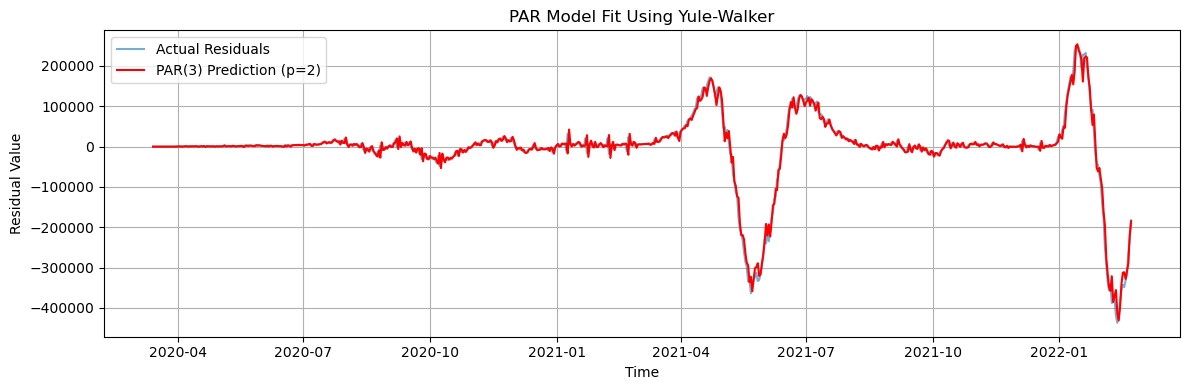

In [32]:
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import yule_walker
import matplotlib.pyplot as plt

# === INPUT: residual series from previous codifference steps ===
y = residual_series.values
index = residual_series.index

# === AIC-based selection ===
def compute_par_aic(y, p, L):
    n = len(y)
    phase_data = {s: [] for s in range(p)}
    total_residuals = []
    k_total = 0

    for t in range(p * L, n):
        phase = t % p
        lags = y[t - L:t][::-1]
        target = y[t]
        phase_data[phase].append((lags, target))

    for s in range(p):
        data_s = phase_data[s]
        if len(data_s) <= L:
            continue
        targets = np.array([target for _, target in data_s])
        if len(targets) < L + 1:
            continue
        try:
            rho, sigma = yule_walker(targets, order=L)
            k_total += L
            preds = []
            for lags, actual in data_s:
                if len(lags) == L:
                    pred = np.dot(rho, lags)
                    preds.append(actual - pred)
            total_residuals.extend(preds)
        except:
            continue

    rss = np.sum(np.square(total_residuals))
    T = len(total_residuals)
    if T == 0 or rss == 0:
        return np.inf
    aic = T * np.log(rss / T) + 2 * k_total
    return aic

# === Search best (p, L) ===
best_aic = np.inf
best_p = None
best_L = None

for p in range(2, 31, 2):
    for L in range(1, 4):
        aic = compute_par_aic(y, p, L)
        if aic < best_aic:
            best_aic = aic
            best_p = p
            best_L = L

print(f"Best Period (p): {best_p}")
print(f"Best Order (L): {best_L}")
print(f"Minimum AIC: {best_aic:.2f}")

# === Fit PAR(best_p, best_L) ===
phi = {}
phase_data = {s: [] for s in range(best_p)}
for t in range(best_p * best_L, len(y)):
    phase = t % best_p
    lags = y[t - best_L:t][::-1]
    target = y[t]
    phase_data[phase].append((lags, target))

for s in range(best_p):
    data_s = phase_data[s]
    targets = np.array([target for _, target in data_s])
    try:
        rho, sigma = yule_walker(targets, order=best_L)
        phi[s] = rho
    except:
        phi[s] = np.zeros(best_L)

# === Predict using fitted model ===
fitted = np.zeros_like(y)
for t in range(best_p * best_L, len(y)):
    phase = t % best_p
    coefs = phi.get(phase, np.zeros(best_L))
    lag_vec = y[t - best_L:t][::-1]
    fitted[t] = np.dot(coefs, lag_vec)

# === Plot Actual vs Predicted ===
plt.figure(figsize=(12, 4))
plt.plot(index, y, label='Actual Residuals', alpha=0.6)
plt.plot(index, fitted, label=f'PAR({best_L}) Prediction (p={best_p})', color='red')
plt.title('PAR Model Fit Using Yule-Walker')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Section 5: PAR Model with Normalized Covariation

This method replaces classical autocovariances with **Normalized Covariation (NCV)** to handle **infinite variance** data.

Key advantages:
- Robust against heavy tails.
- Does not assume second-order moments exist.

Useful for fitting α-stable PAR processes.


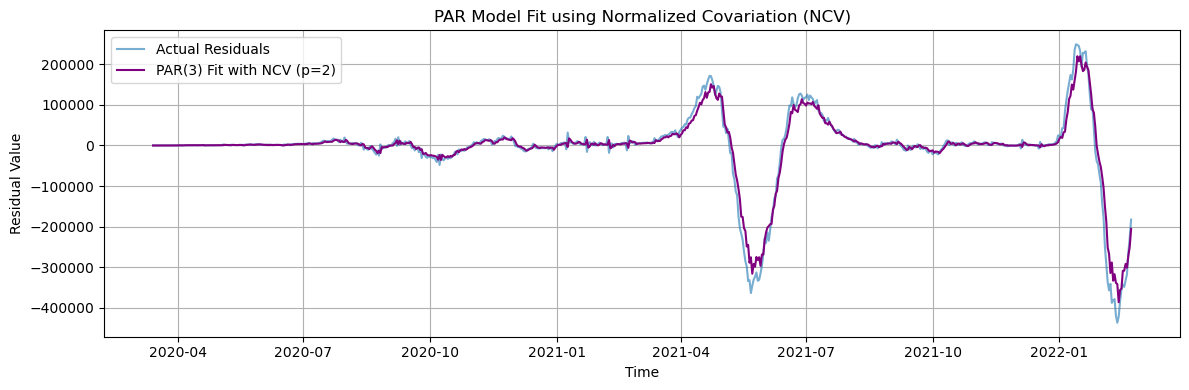

✅ Best Period (p): 2
✅ Best Order (L): 3
✅ Minimum AIC (NCV): 13887.16


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === INPUT: residual series ===
y = residual_series.values
index = residual_series.index

# === Robust MAD function ===
def mad(x):
    return np.median(np.abs(x - np.median(x))) + 1e-8  # add epsilon to avoid zero-div

# === Normalized Covariation function (robust) ===
def ncv_autocorr(series, lag):
    if lag == 0:
        return 1.0
    x = series[:-lag]
    y = series[lag:]
    return np.median(x * y) / (mad(x) * mad(y))

# === Yule-Walker style equation using NCV ===
def ncv_yule_walker(series, L):
    r = [ncv_autocorr(series, h) for h in range(L + 1)]  # r[0], r[1], ..., r[L]
    R = np.array([[r[abs(i - j)] for j in range(L)] for i in range(L)])
    r_vec = np.array(r[1:L+1])
    try:
        phi = np.linalg.solve(R, r_vec)
    except np.linalg.LinAlgError:
        phi = np.zeros(L)
    return phi

# === Fit PAR(p, L) using NCV method ===
def fit_par_ncv(y, p, L):
    n = len(y)
    phi = {}
    fitted = np.zeros_like(y)
    
    for s in range(p):
        # Phase series: {y_t | t mod p = s}
        y_s = np.array([y[t] for t in range(p * L, n) if t % p == s])
        if len(y_s) <= L + 1:
            phi[s] = np.zeros(L)
            continue
        phi[s] = ncv_yule_walker(y_s, L)

    for t in range(p * L, n):
        s = t % p
        if s in phi:
            lag_vec = y[t - L:t][::-1]
            fitted[t] = np.dot(phi[s], lag_vec)

    return phi, fitted

# === AIC Computation ===
def compute_par_ncv_aic(y, p, L):
    n = len(y)
    phi, fitted = fit_par_ncv(y, p, L)
    residuals = y[p * L:] - fitted[p * L:]
    rss = np.sum(residuals ** 2)
    T = len(residuals)
    if T == 0 or rss == 0:
        return np.inf
    aic = T * np.log(rss / T) + 2 * (p * L)
    return aic

# === Search for best (p, L) ===
best_aic = np.inf
best_p = None
best_L = None

for p in range(2, 31, 2):  # Try periods: 2, 4, ..., 30
    for L in range(1, 4):  # Try AR orders: 1, 2, 3
        aic = compute_par_ncv_aic(y, p, L)
        if aic < best_aic:
            best_aic = aic
            best_p = p
            best_L = L

# === Final Model Fit with Best (p, L) ===
phi, fitted = fit_par_ncv(y, best_p, best_L)

# === Plot Actual vs Predicted ===
plt.figure(figsize=(12, 4))
plt.plot(index, y, label='Actual Residuals', alpha=0.6)
plt.plot(index, fitted, label=f'PAR({best_L}) Fit with NCV (p={best_p})', color='purple')
plt.title('PAR Model Fit using Normalized Covariation (NCV)')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Report Best Parameters ===
print(f"✅ Best Period (p): {best_p}")
print(f"✅ Best Order (L): {best_L}")
print(f"✅ Minimum AIC (NCV): {best_aic:.2f}")



# Section 6: PAR Estimation via FLOC-Based Yule–Walker

This section introduces a **Frequency-Limited Order Covariation (FLOC)**-based modification of the Yule–Walker method for α-stable periodic data.

Highlights:
- Replaces classical autocovariance with FLOC-based dependency measure.
- Handles infinite variance and captures periodic structure.
- Particularly suitable for alpha-stable PAR modeling.

The estimated parameters are used to fit and forecast periodic components in data where standard methods fail.


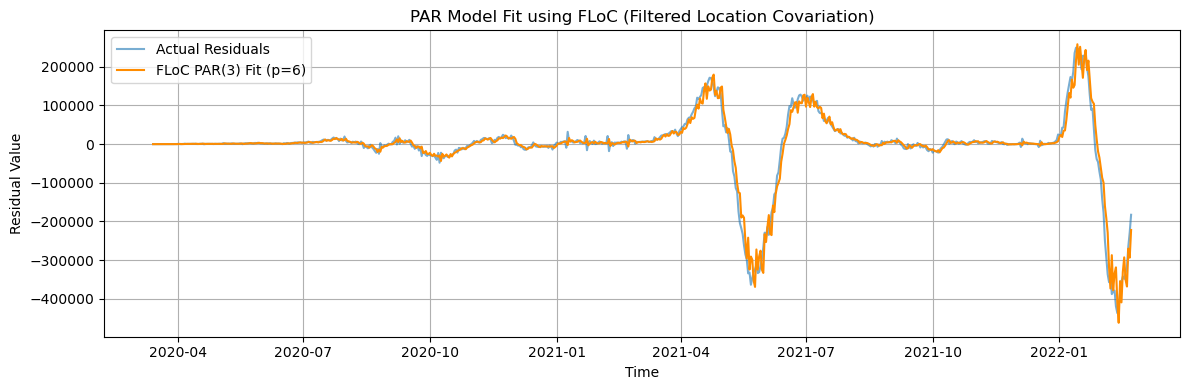

✅ Best Period (p): 6
✅ Best Order (L): 3
✅ Minimum AIC (FLoC): 13677.65


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Input residuals ===
y = residual_series.values
index = residual_series.index

# === Robust quantile estimator ===
def floc(x, y, tau=0.5):
    """
    FLoC estimator: ratio of quantiles of product vs square.
    Returns slope estimate for regressing y on x using quantile ratio.
    """
    numerator = np.quantile(y * x, tau)
    denominator = np.quantile(x ** 2, tau) + 1e-8  # to avoid division by zero
    return numerator / denominator

# === Fit AR(L) using FLoC instead of Yule-Walker ===
def floc_ar_coeffs(series, L, tau=0.5):
    coeffs = []
    for lag in range(1, L + 1):
        x = series[:-lag]
        y = series[lag:]
        coeff = floc(x, y, tau)
        coeffs.append(coeff)
    return np.array(coeffs)

# === Fit PAR(p, L) using FLoC dependencies ===
def fit_par_floc(y, p, L, tau=0.5):
    n = len(y)
    phi = {}
    fitted = np.zeros_like(y)
    
    for s in range(p):
        # Phase series: all y_t where t % p == s
        y_s = np.array([y[t] for t in range(p * L, n) if t % p == s])
        if len(y_s) <= L + 1:
            phi[s] = np.zeros(L)
            continue
        phi[s] = floc_ar_coeffs(y_s, L, tau)

    for t in range(p * L, n):
        s = t % p
        lag_vec = y[t - L:t][::-1]
        fitted[t] = np.dot(phi.get(s, np.zeros(L)), lag_vec)

    return phi, fitted

# === Compute AIC for FLoC-PAR ===
def compute_par_floc_aic(y, p, L):
    phi, fitted = fit_par_floc(y, p, L)
    residuals = y[p * L:] - fitted[p * L:]
    rss = np.sum(residuals ** 2)
    T = len(residuals)
    if T == 0 or rss == 0:
        return np.inf
    aic = T * np.log(rss / T) + 2 * (p * L)
    return aic

# === Grid search best (p, L) using AIC ===
best_aic = np.inf
best_p = None
best_L = None

for p in range(2, 31, 2):  # periods: 2, 4, ..., 30
    for L in range(1, 4):  # orders: 1, 2, 3
        aic = compute_par_floc_aic(y, p, L)
        if aic < best_aic:
            best_aic = aic
            best_p = p
            best_L = L

# === Final Fit using best (p, L) ===
phi, fitted = fit_par_floc(y, best_p, best_L)

# === Plot Actual vs Predicted ===
plt.figure(figsize=(12, 4))
plt.plot(index, y, label='Actual Residuals', alpha=0.6)
plt.plot(index, fitted, label=f'FLoC PAR({best_L}) Fit (p={best_p})', color='darkorange')
plt.title('PAR Model Fit using FLoC (Filtered Location Covariation)')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Report Best Parameters ===
print(f"✅ Best Period (p): {best_p}")
print(f"✅ Best Order (L): {best_L}")
print(f"✅ Minimum AIC (FLoC): {best_aic:.2f}")


Comparing all above PAR models , lesser MAE and RMSE , better the model.

Classical Yule-Walker PAR:
  MAE  = 40206.2699
  RMSE = 84546.7185

NCV-based PAR:
  MAE  = 32423.9775
  RMSE = 68509.8425

FLoC-based PAR:
  MAE  = 28616.0126
  RMSE = 60926.6673

=== Error Comparison Table ===
          Model           MAE          RMSE
0  Classical YW  40206.269904  84546.718538
1           NCV  32423.977511  68509.842533
2          FLoC  28616.012630  60926.667275


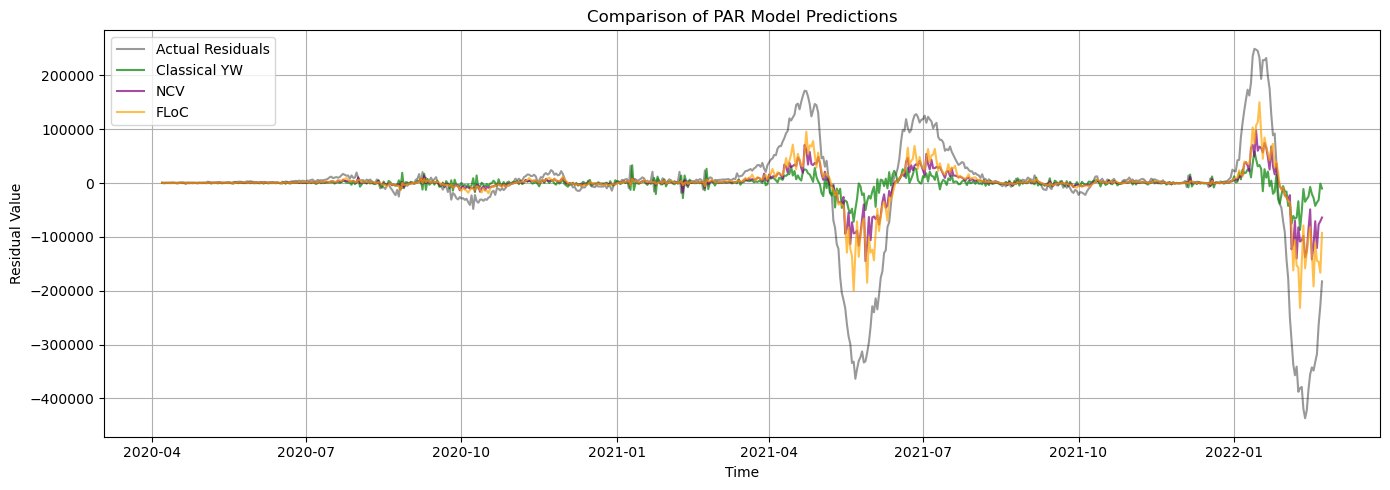

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Input ===
y = residual_series.values
index = residual_series.index

# === Utility: MAD for robust estimation ===
def mad(x):
    return np.median(np.abs(x - np.median(x))) + 1e-8

# === NCV functions ===
def ncv_autocorr(series, lag):
    if lag == 0:
        return 1.0
    x = series[:-lag]
    y = series[lag:]
    return np.median(x * y) / (mad(x) * mad(y))

def ncv_yule_walker(series, L):
    r = [ncv_autocorr(series, h) for h in range(L + 1)]
    R = np.array([[r[abs(i - j)] for j in range(L)] for i in range(L)])
    r_vec = np.array(r[1:L+1])
    try:
        phi = np.linalg.solve(R, r_vec)
    except np.linalg.LinAlgError:
        phi = np.zeros(L)
    return phi

# === FLoC functions ===
def floc(x, y, tau=0.5):
    return np.quantile(y * x, tau) / (np.quantile(x ** 2, tau) + 1e-8)

def floc_ar_coeffs(series, L, tau=0.5):
    coeffs = []
    for lag in range(1, L + 1):
        x = series[:-lag]
        y_ = series[lag:]
        coeff = floc(x, y_, tau)
        coeffs.append(coeff)
    return np.array(coeffs)

# === General Fitting Functions ===
def fit_par_model(y, p, L, dep_type="classical"):
    n = len(y)
    phi = {}
    fitted = np.zeros_like(y)

    for s in range(p):
        y_s = np.array([y[t] for t in range(p * L, n) if t % p == s])
        if len(y_s) <= L + 1:
            phi[s] = np.zeros(L)
            continue
        if dep_type == "classical":
            try:
                rho, _ = yule_walker(y_s, order=L)
                phi[s] = rho
            except:
                phi[s] = np.zeros(L)
        elif dep_type == "ncv":
            phi[s] = ncv_yule_walker(y_s, L)
        elif dep_type == "floc":
            phi[s] = floc_ar_coeffs(y_s, L)
        else:
            raise ValueError("Invalid dep_type")

    for t in range(p * L, n):
        s = t % p
        lag_vec = y[t - L:t][::-1]
        fitted[t] = np.dot(phi.get(s, np.zeros(L)), lag_vec)

    return phi, fitted

# === Error Function ===
def compute_errors(y_true, y_pred, model_name):
    start = np.argmax(y_pred != 0)
    y_true = y_true[start:]
    y_pred = y_pred[start:]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name}:\n  MAE  = {mae:.4f}\n  RMSE = {rmse:.4f}\n")
    return mae, rmse, y_pred

# === Set p and L manually or tune via AIC ===
p = 12  # example seasonality
L = 2   # example AR order

# === Fit Models ===
phi_classical, fitted_classical = fit_par_model(y, p, L, dep_type="classical")
phi_ncv,       fitted_ncv       = fit_par_model(y, p, L, dep_type="ncv")
phi_floc,      fitted_floc      = fit_par_model(y, p, L, dep_type="floc")

# === Compute Errors ===
mae_c, rmse_c, yhat_c = compute_errors(y, fitted_classical, "Classical Yule-Walker PAR")
mae_n, rmse_n, yhat_n = compute_errors(y, fitted_ncv, "NCV-based PAR")
mae_f, rmse_f, yhat_f = compute_errors(y, fitted_floc, "FLoC-based PAR")

# === Create Table ===
error_df = pd.DataFrame({
    "Model": ["Classical YW", "NCV", "FLoC"],
    "MAE": [mae_c, mae_n, mae_f],
    "RMSE": [rmse_c, rmse_n, rmse_f]
})
print("=== Error Comparison Table ===")
print(error_df)

# === Plot ===
# Determine the warm-up point for all models
start = max(p * L, np.argmax(fitted_classical != 0), np.argmax(fitted_ncv != 0), np.argmax(fitted_floc != 0))

plt.figure(figsize=(14, 5))
plt.plot(index[start:], y[start:], label="Actual Residuals", color='black', alpha=0.4)
plt.plot(index[start:], fitted_classical[start:], label="Classical YW", color='green', alpha=0.7)
plt.plot(index[start:], fitted_ncv[start:], label="NCV", color='purple', alpha=0.7)
plt.plot(index[start:], fitted_floc[start:], label="FLoC", color='orange', alpha=0.7)

plt.title("Comparison of PAR Model Predictions")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


